In [335]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'svg'

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [336]:
item_categ_path = 'item_categories.csv'
items_path = 'items.csv'
sample_submission_path = 'sample_submission.csv'
sales_train_path = 'sales_train.csv'
shops_path = 'shops.csv'
test_path = 'test.csv'

# Описание набора данных

Вам предоставляются ежедневные данные о продажах. Задача состоит в том, чтобы спрогнозировать общее количество товаров, проданных в каждом магазине для тестовой выборки. Обратите внимание, что список магазинов и товаров немного меняется каждый месяц. Создание надежной модели, способной справиться с такими ситуациями, является частью задачи.

# Описания файлов

**sales_train.csv** - тренировочный набор. Ежедневные данные с января 2013 г. по октябрь 2015 г.

**test.csv** - тестовый набор. Вам необходимо спрогнозировать продажи этих магазинов и товаров на ноябрь 2015 года.

**sample_submission.csv** - образец файла представления в правильном формате.

**items.csv** - дополнительная информация о предметах/продуктах.

**item_categories.csv** - дополнительная информация о категориях товаров.

**shops.csv**- дополнительная информация о магазинах.

# Поля данных

**ID** - идентификатор, представляющий кортеж (магазин, товар) в тестовом наборе

**shop_id** - уникальный идентификатор магазина

**item_id** - уникальный идентификатор товара

**item_category_id** - уникальный идентификатор категории товара

**item_cnt_day** - количество проданных товаров. Вы прогнозируете ежемесячную сумму этой меры

**item_price** - текущая цена товара

**date** - дата в формате dd/mm/yyyy

**date_block_num** - последовательный номер месяца, используемый для удобства. Январь 2013 г. — 0, февраль 2013 г. — 1,..., октябрь 2015 г. — 33

**item_name** - название предмета

**shop_name** - название магазина

**item_category_name** - название категории товара

In [337]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [338]:
item_categories = pd.read_csv(item_categ_path, sep=',')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [339]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [340]:
item_categories.shape

(84, 2)

In [341]:
item = pd.read_csv(items_path, sep=',')
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [342]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [343]:
item.shape

(22170, 3)

In [344]:
sample_submission = pd.read_csv(sample_submission_path, sep=',')
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [345]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


In [346]:
sample_submission.shape

(214200, 2)

In [347]:
sample_submission = reduce_mem_usage(sample_submission)

Memory usage of dataframe is 3.27 MB
Memory usage after optimization is: 1.63 MB
Decreased by 50.0%


In [348]:
sales_train = pd.read_csv(sales_train_path, sep=',')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [349]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [350]:
sales_train.shape

(2935849, 6)

In [351]:
sales_train = reduce_mem_usage(sales_train)

Memory usage of dataframe is 134.39 MB
Memory usage after optimization is: 39.24 MB
Decreased by 70.8%


In [352]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype   
---  ------          -----   
 0   date            category
 1   date_block_num  int8    
 2   shop_id         int8    
 3   item_id         int16   
 4   item_price      float32 
 5   item_cnt_day    float32 
dtypes: category(1), float32(2), int16(1), int8(2)
memory usage: 39.2 MB


In [353]:
shops = pd.read_csv(shops_path, sep=',')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [354]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [355]:
shops.shape

(60, 2)

In [356]:
test = pd.read_csv(test_path, sep=',')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [357]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [358]:
test.shape

(214200, 3)

In [359]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 4.90 MB
Memory usage after optimization is: 1.43 MB
Decreased by 70.8%


In [360]:
df_eda = pd.merge(sales_train, shops, how='left', left_on = 'shop_id', right_on = 'shop_id')
df_eda = pd.merge(df_eda, item, how='left', left_on='item_id', right_on='item_id')
df_eda = pd.merge(df_eda, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
df_eda.drop(['item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
df_eda.head()

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name
0,2013-02-01,0,999.000000,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray
1,2013-03-01,0,899.000000,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,Музыка - Винил
2,2013-05-01,0,899.000000,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,Музыка - Винил
3,2013-06-01,0,1709.050049,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,Музыка - Винил
4,2013-01-15,0,1099.000000,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),Музыка - CD фирменного производства


In [361]:
print(df_eda.shape)

(2935849, 7)


In [362]:
df_eda.keys()

Index(['date', 'date_block_num', 'item_price', 'item_cnt_day', 'shop_name',
       'item_name', 'item_category_name'],
      dtype='object')

In [363]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column              Dtype   
---  ------              -----   
 0   date                category
 1   date_block_num      int8    
 2   item_price          float32 
 3   item_cnt_day        float32 
 4   shop_name           object  
 5   item_name           object  
 6   item_category_name  object  
dtypes: category(1), float32(2), int8(1), object(3)
memory usage: 120.4+ MB


In [364]:
df_eda.duplicated().sum()

6

In [365]:
df_eda[df_eda.duplicated(keep=False)]

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name
76961,2013-05-01,0,149.0,1.0,"Химки ТЦ ""Мега""",УЧЕНИК ЧАРОДЕЯ (регион),Кино - DVD
76962,2013-05-01,0,149.0,1.0,"Химки ТЦ ""Мега""",УЧЕНИК ЧАРОДЕЯ (регион),Кино - DVD
1435365,2014-02-23,13,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1435367,2014-02-23,13,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1496765,2014-03-23,14,999.0,1.0,"Москва МТРЦ ""Афи Молл""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1496766,2014-03-23,14,999.0,1.0,"Москва МТРЦ ""Афи Молл""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1671872,2014-01-05,16,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1671873,2014-01-05,16,999.0,1.0,"Тюмень ТЦ ""Гудвин""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1866322,2014-12-07,18,999.0,1.0,"Москва ТРК ""Атриум""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360
1866340,2014-12-07,18,999.0,1.0,"Москва ТРК ""Атриум""","Far Cry 3 (Classics) [Xbox 360, русская версия]",Игры - XBOX 360


In [366]:
df_eda.drop_duplicates(keep='first', inplace=True)
df_eda.duplicated().sum()

0

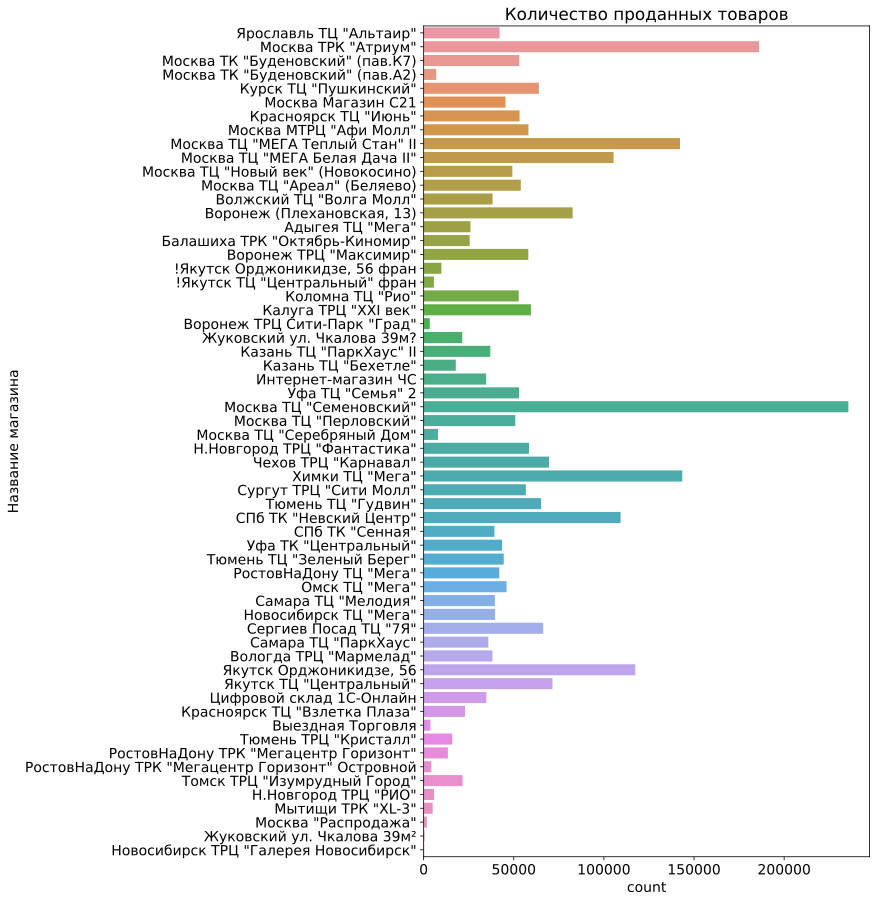

In [367]:
plt.figure(figsize=(8, 15))
sns.countplot(y=df_eda['shop_name'])

plt.ylabel('Название магазина')
plt.title('Количество проданных товаров')
plt.show()

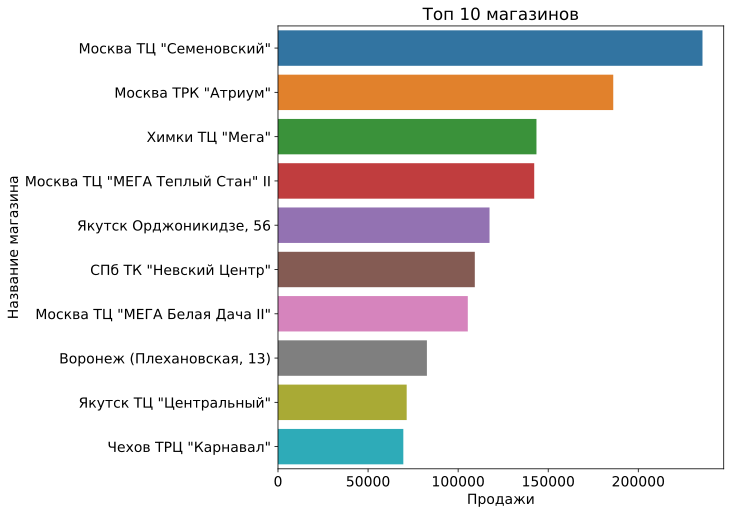

In [368]:
top_10_selling_item = df_eda['shop_name'].value_counts().head(10)
top_10_selling_item = top_10_selling_item.to_frame().reset_index()
top_10_selling_item.columns = ['shop_name', 'count']
plt.figure(figsize=(8, 8))
sns.barplot(data=top_10_selling_item, x='count', y='shop_name')
plt.title('Топ 10 магазинов')
plt.ylabel('Название магазина')
plt.xlabel('Продажи')
plt.show()

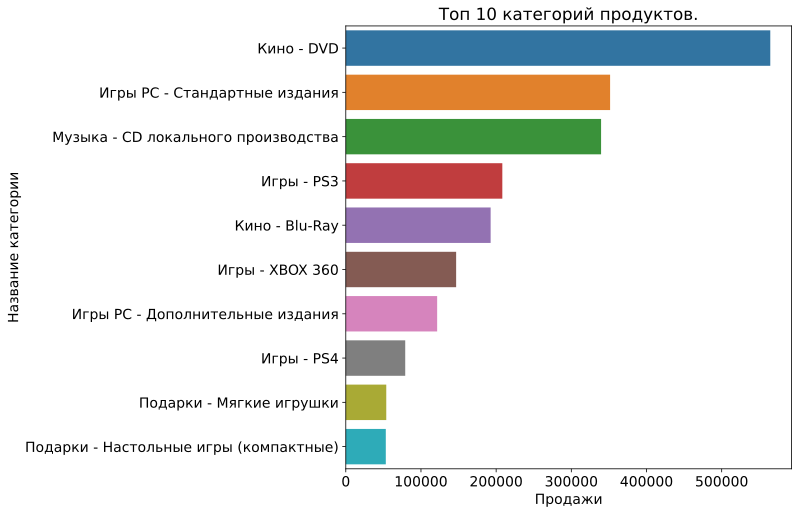

In [369]:
top_10_selling_category = df_eda['item_category_name'].value_counts().head(10)
top_10_selling_category = top_10_selling_category.to_frame().reset_index()
top_10_selling_category.columns = ['item_name', 'count']
plt.figure(figsize=(8, 8))
sns.barplot(data=top_10_selling_category, x='count', y='item_name')
plt.title('Топ 10 категорий продуктов.')
plt.ylabel('Название категории')
plt.xlabel('Продажи')
plt.show()

In [370]:
def plot_trend(columns):
    for column in columns:
        movies = df_eda[df_eda['item_category_name'] == column]
        movies = movies.groupby('date_block_num')['item_cnt_day'].sum().to_frame().reset_index()
        plt.figure(figsize=(20,4))
        plt.axhline (y =movies['item_cnt_day'].mean(), color='red', linewidth = 1, linestyle ='dashed',
                     label = 'Средний объем продаж за все время.')
        sns.lineplot(data=movies, x='date_block_num', y='item_cnt_day', label = 'Trend line.')
        plt.title('Склонность к покупке ' + str(column) + '.', fontsize=14)
        plt.legend(loc = 'upper right')
        plt.xlabel('Количество месяцев (с января 2013 г. по октябрь 2015 г.)')
        plt.ylabel('Товары проданы')
        plt.show()
        print('\n')

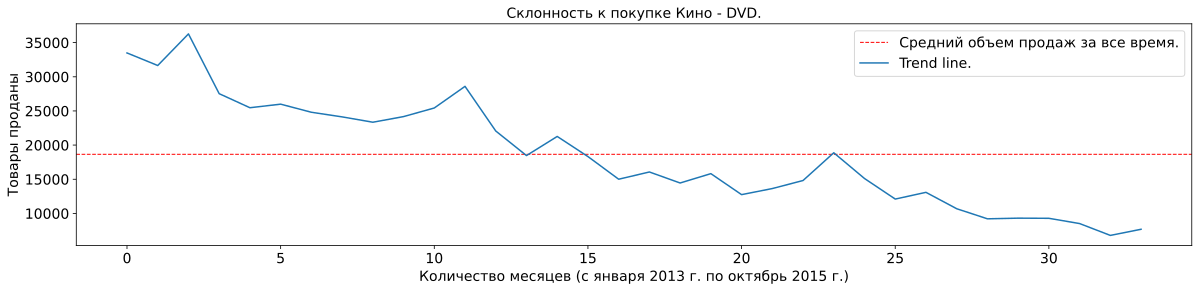

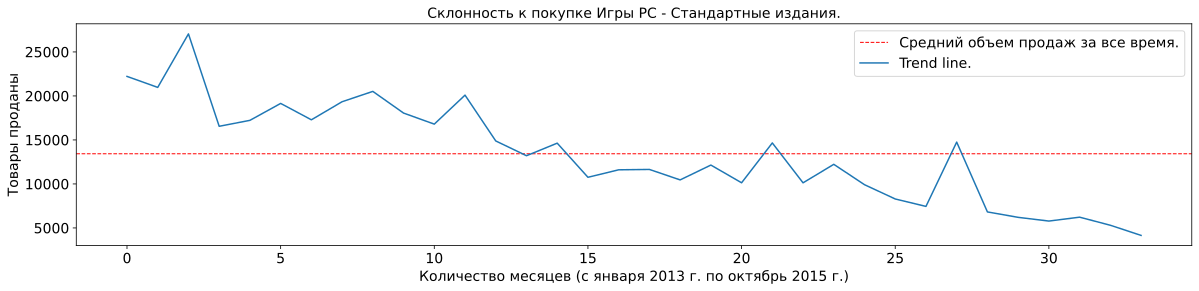

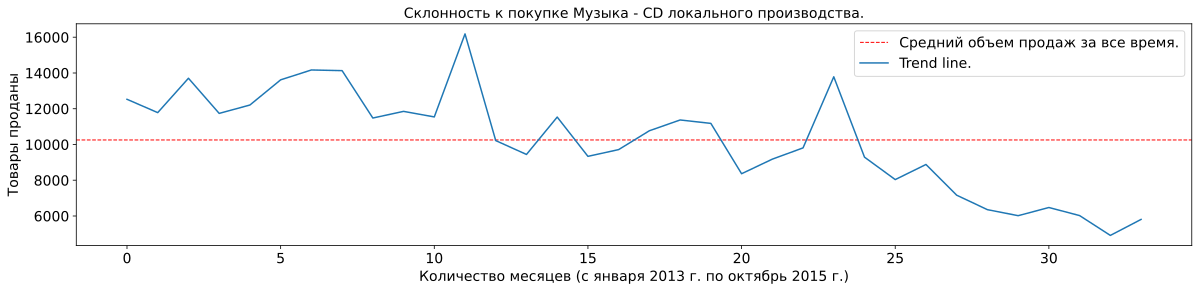

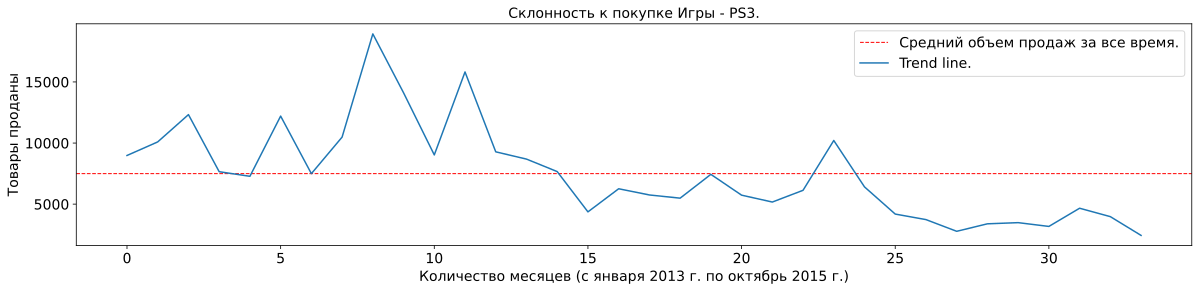

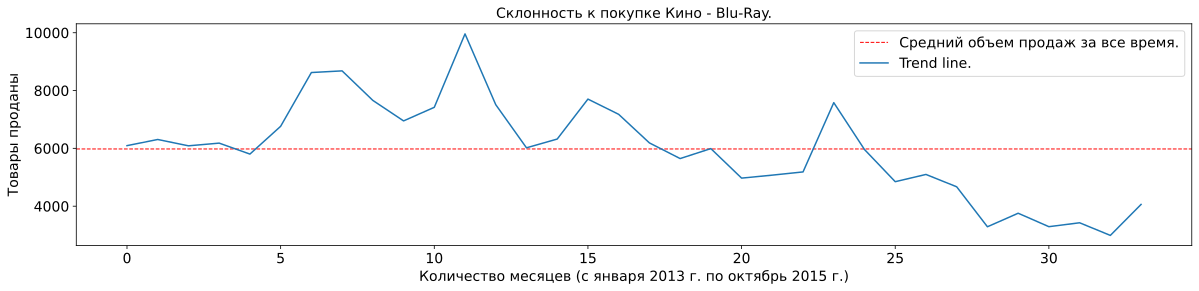

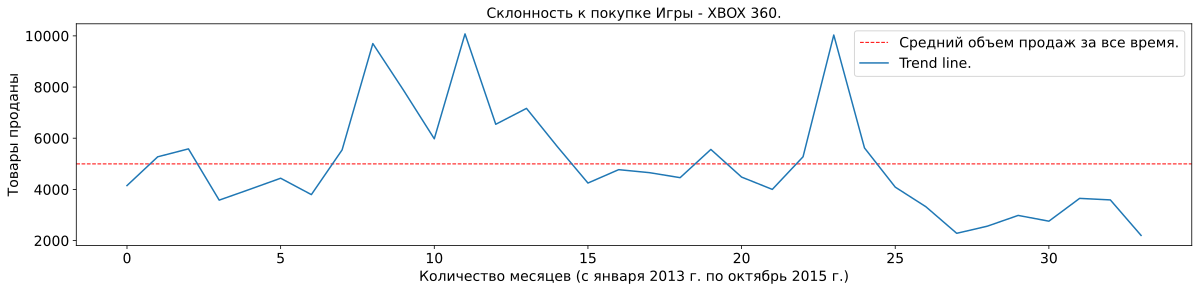

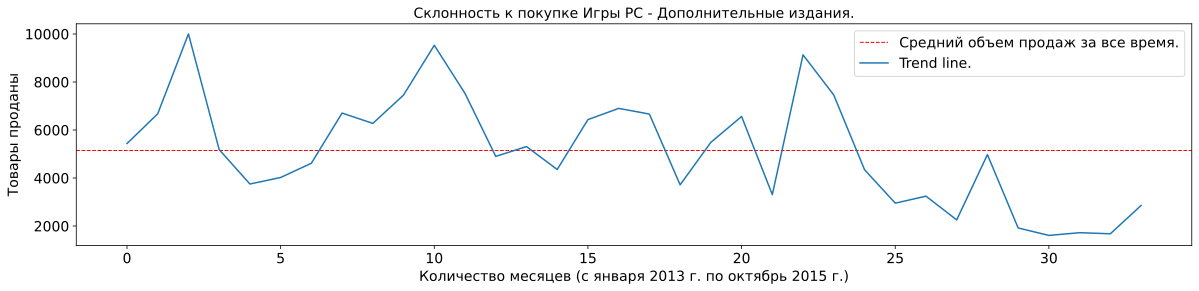

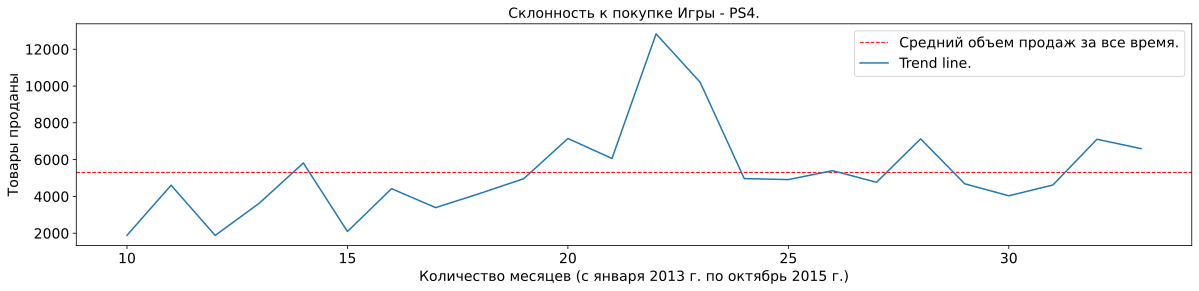

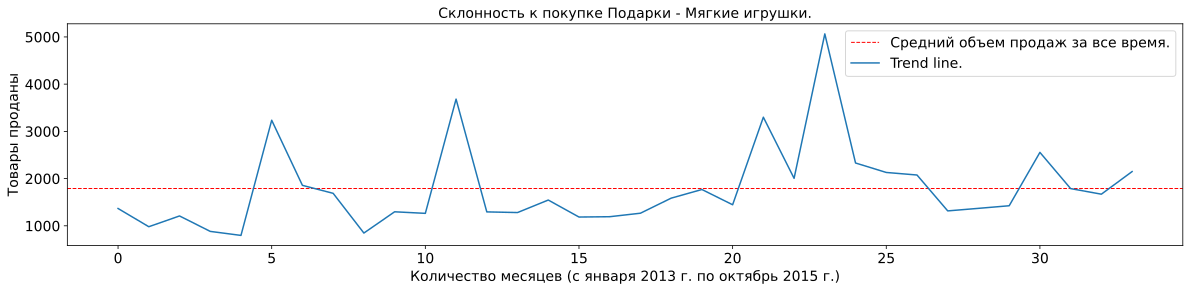

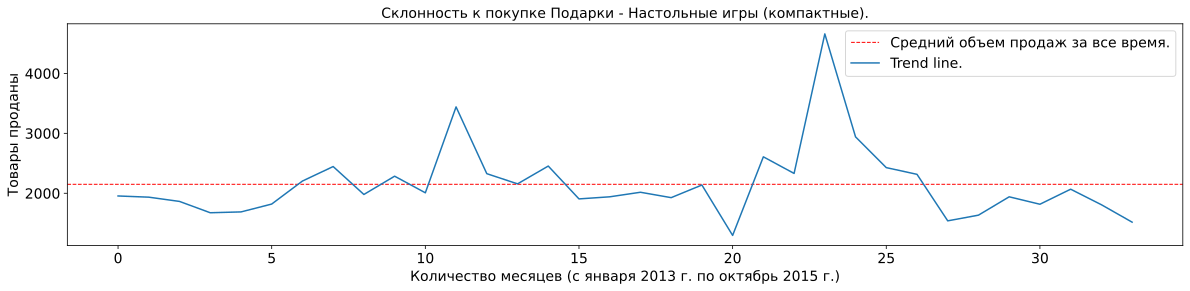

In [371]:
plot_trend(list(top_10_selling_category['item_name']))

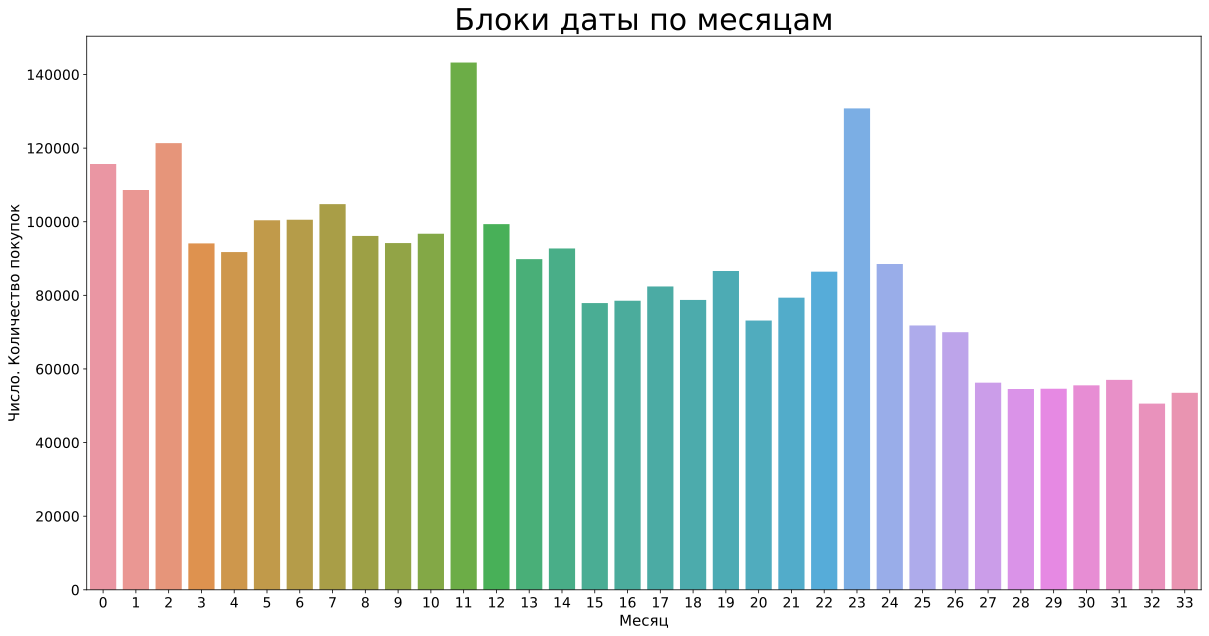

In [372]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(sales_train['date_block_num'])
plt.title('Блоки даты по месяцам', fontsize = 30)
plt.xlabel('Месяц', fontsize = 15)
plt.ylabel('Число. Количество покупок', fontsize = 15)
plt.show()

In [373]:
data = sales_train.groupby([sales_train['date'].apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()

In [374]:
data = data[['date','item_id','shop_id','item_cnt_day']]

In [375]:
data = data.pivot_table(index=['item_id','shop_id'], columns = 'date', values = 'item_cnt_day', fill_value = 0).reset_index()

In [376]:
data.head(10)

date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [377]:
test = pd.merge(test, data, on = ['item_id', 'shop_id'], how = 'left')

In [378]:
test.fillna(0, inplace = True)

In [379]:
reduce_mem_usage(test)
test.info()

Memory usage of dataframe is 61.90 MB
Memory usage after optimization is: 32.48 MB
Decreased by 47.5%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 39 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ID       214200 non-null  int32  
 1   shop_id  214200 non-null  int8   
 2   item_id  214200 non-null  int16  
 3   2013-01  214200 non-null  float32
 4   2013-02  214200 non-null  float32
 5   2013-03  214200 non-null  float32
 6   2013-04  214200 non-null  float32
 7   2013-05  214200 non-null  float32
 8   2013-06  214200 non-null  float32
 9   2013-07  214200 non-null  float32
 10  2013-08  214200 non-null  float32
 11  2013-09  214200 non-null  float32
 12  2013-10  214200 non-null  float32
 13  2013-11  214200 non-null  float32
 14  2013-12  214200 non-null  float32
 15  2014-01  214200 non-null  float32
 16  2014-02  214200 non-null  float32
 17  2014-03  214200 non-null  float32
 18  20

In [380]:
x_train0 = test.drop(['2015-11', 'item_id', 'shop_id'], axis = 1)
y_train0 = test['2015-11']

In [381]:
x_test = test.drop(['2013-01', 'item_id', 'shop_id'], axis = 1)

In [382]:
print("Shape of x_train0 :", x_train0.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_train0.shape)

Shape of x_train0 : (214200, 36)
Shape of x_test : (214200, 36)
Shape of y_test : (214200,)


In [383]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train0, y_train0, test_size=0.3, shuffle=True, random_state=500)

In [384]:
print("Shape of x_train :", x_train.shape)
print("Shape of x_valid :", x_valid.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_valid :", y_valid.shape)

Shape of x_train : (149940, 36)
Shape of x_valid : (64260, 36)
Shape of y_train : (149940,)
Shape of y_valid : (64260,)


In [385]:
model = RandomForestRegressor(n_estimators=1000, max_depth=13, random_state=100)

In [386]:
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=13, n_estimators=1000, random_state=100)

In [387]:
y_pred = model.predict(x_valid)

In [388]:
check_test = pd.DataFrame({'y_valid' : y_valid, 'y_pred' : y_pred.flatten()}, columns = ['y_valid', 'y_pred'])
check_test.head(20)

,y_valid,y_pred
191832,0.0,0.070009
177308,0.0,0.010295
202864,0.0,0.010295
72819,0.0,0.231647
10294,0.0,0.220388
102266,0.0,0.089555
82355,0.0,0.367548
103661,0.0,0.010858
49274,0.0,0.010295
188902,0.0,0.164825


In [389]:
r2_score(y_valid, y_pred)

0.7646780213886695